In [1]:
%%bash
nrnivmodl

/usr/bin/xcrun
/Users/anatolii-sorokin/Documents/Projects/neuro-trafic
Mod files: "./h.mod" "./kadist.mod" "./kaprox.mod" "./kdrca1.mod" "./km.mod" "./na3n.mod" "./naxn.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import math
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
#from PyNeuronToolbox import neuromorpho,morphology
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate,load
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm
%matplotlib inline
np.random.seed(123456789)

import re
import pandas as pd

DC = 10 # diffusion coeff [microns^2 s^-1]

cellname = 'dgyrus'
#cellname = 'granule'
#neuromorpho.download('041015-vehicle1', filename=cellname+'_morph.swc')
#cell = morphology.load(cellname+'_morph.swc',use_axon=False)
#cell = load(cellname+'_morph.swc',use_axon=False)


In [3]:
import sushibelt
import Edita_DG_density_10reg_1dv_model_dvonly as model

import time
tnorm = np.sum(model.target ** 2)

2024-10-31 14:51:24,233 :: INFO :: function defined
2024-10-31 14:51:24,246 :: INFO :: data read


In [4]:
N=model.N
N

287

In [5]:
tdf=pd.read_csv('data/DG_seg_mapping.csv')
abbDG=tdf['abb']
abbT={}
segIdx={}
for i in range(N):
    abbT[abbDG[i]] = 1+ abbT.get(abbDG[i],0)
    ll=segIdx.get(abbDG[i],[])
    ll.append(i)
    segIdx[abbDG[i]] = ll


In [6]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,allsec_preorder(h)[0](0.5),segment)


In [7]:
tdf=pd.read_csv('data/DG_seg_mapping.csv')
tdf

,Unnamed: 0,N,Name,abb,DtS
0,0,0,dgyrus_morph.soma[0],rd1,0.000000
1,1,1,dgyrus_morph.dend[0],rd1,7.512102
2,2,2,dgyrus_morph.dend[0],rd1,7.512102
3,3,3,dgyrus_morph.dend[0],rd1,7.512102
4,4,4,dgyrus_morph.dend[0],rd1,7.512102
...,...,...,...,...,...
282,282,282,dgyrus_morph.dend[5],rd5,91.692424
283,283,283,dgyrus_morph.dend[5],rd5,91.692424
284,284,284,dgyrus_morph.dend[5],rd5,91.692424
285,285,285,dgyrus_morph.dend[5],rd5,91.692424


# 18 month data

In [8]:
#expD=pd.read_csv('data/DG_intensity_values_15072024.csv')
expD=pd.read_csv('data/DG_density_values_15072024.csv')
bgSignal=1e-5
cname0='D0M18'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

cname7='D7M18'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #results to fit to
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point
model.target=target
model.targSD=targSD
model.tnorm=tnorm

## Degradation adjusted

In [9]:
par_dev = model.opt_par
mProp = par_dev[2]
dv_val = [-5.343599446612984]
#par_dev[13:] = [
cost = 2.633674515473845e-05
chi2 = 2.820840080143533

In [10]:
model.dinit=dinit
utrace = model.calcUtrace(dv_val)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], model.segIdx, model.expD['Abbreviation'], fun=np.sum)

In [11]:
{'F' : par_dev[0],
'Ctau' : par_dev[1],
'mProp' : par_dev[2],
'(1-mProp)' : (1-par_dev[2]),
'demand_rd1' : par_dev[3],
'demand_rd2' : par_dev[4],
'demand_rd3' : par_dev[5],
'demand_rd4' : par_dev[6],
'demand_rd5' : par_dev[7],
'demand_rd6' : par_dev[8],
'demand_rd7' : par_dev[9],
'demand_rd8' : par_dev[10],
'demand_rd9' : par_dev[11],
'demand_rd10' : par_dev[12],
'dv' : 10 ** dv_val[0],
'T1/2': np.log(2)*7/((10 ** dv_val[0]) * day7),
'norm_factor' : (1-mProp),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - model.target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - model.target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - model.target)/model.targSD) ** 2),
'cost' : cost,
'Chi2' : chi2
}

{'F': 0.010254232013526715,
 'Ctau': -5.638032179385583,
 'mProp': 0.4901989246102767,
 '(1-mProp)': 0.5098010753897233,
 'demand_rd1': 1.0346217672476097e-07,
 'demand_rd2': 0.029242261750488406,
 'demand_rd3': 0.01218622680694604,
 'demand_rd4': 0.041390587450443085,
 'demand_rd5': 0.06704294550203627,
 'demand_rd6': 0.08976537459084287,
 'demand_rd7': 0.1513671679744187,
 'demand_rd8': 0.6105826545927185,
 'demand_rd9': 0.543743857008341,
 'demand_rd10': 0.28125287183335723,
 'dv': 4.533154837700139e-06,
 'T1/2': 1.7697469200294458,
 'norm_factor': 0.5098010753897233,
 'sum_resM': 0.27006890404998574,
 'sum_resF': 0.08570647023721037,
 'sum_tot': 0.3557753742871961,
 'err': 2.6336745154738247e-05,
 'err_norm': 0.00781890734390049,
 'chi2': 2.820840080143543,
 'cost': 2.633674515473845e-05,
 'Chi2': 2.820840080143533}

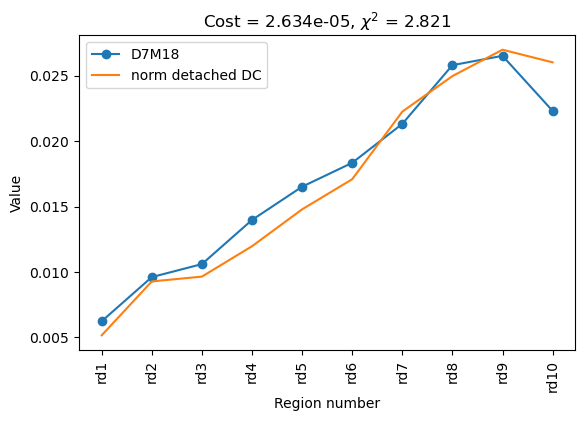

In [12]:
x=np.array(range(model.expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label=cname7)
#ax.plot(x,resM,label='mobile DC')
#ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='norm detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('expEdita_DG_10reg_1dv_18M_fit_density_20241031_target.png')
plt.savefig('expEdita_DG_10reg_1dv_18M_fit_density_20241031_target.pdf')
plt.savefig('expEdita_DG_10reg_1dv_18M_fit_density_20241031_target.svg')

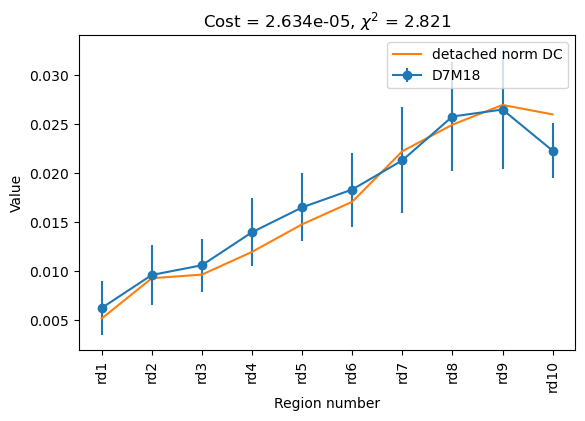

In [13]:
fig, ax = plt.subplots()
#plt.plot(x,target,label=cname7)
ax.errorbar(x,target,targSD,label=cname7, fmt='-o')
#plt.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('expEdita_DG_10reg_1dv_18M_fit_density_20241031_target_error.png')
plt.savefig('expEdita_DG_10reg_1dv_18M_fit_density_20241031_target_error.pdf')
plt.savefig('expEdita_DG_10reg_1dv_18M_fit_density_20241031_target_error.svg')

# Three weeks data

In [ ]:
#expD=pd.read_csv('data/DG_intensity_values_15072024.csv')
expD=pd.read_csv('data/DG_density_values_15072024.csv')
bgSignal=1e-5

cname0='D0W3'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

cname7='D7W3'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #results to fit to
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point


## Degradation adjusted

In [ ]:
dv_val = [-3.2573536255374993]
cost = 7.060707498678246e-08
chi2 = 0.00924209249590049

In [ ]:
model.dinit=dinit
utrace = model.calcUtrace(dv_val)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], model.segIdx, model.expD['Abbreviation'], fun=np.sum)

In [ ]:
model.target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
model.targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #results to fit to
model.tnorm = np.sum(model.target ** 2)
model.costFunction(dv_val)

In [ ]:
{'F' : par_dev[0],
'Ctau' : par_dev[1],
'mProp' : par_dev[2],
'(1-mProp)' : (1-par_dev[2]),
'demand_rd1' : par_dev[3],
'demand_rd2' : par_dev[4],
'demand_rd3' : par_dev[5],
'demand_rd4' : par_dev[6],
'demand_rd5' : par_dev[7],
'demand_rd6' : par_dev[8],
'demand_rd7' : par_dev[9],
'demand_rd8' : par_dev[10],
'demand_rd9' : par_dev[11],
'demand_rd10' : par_dev[12],
'dv' : 10 ** dv_val[0],
'T1/2': np.log(2)*7/((10 ** dv_val[0]) * day7),
'norm_factor' : (1-mProp),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost,
'Chi2' : chi2
}

In [ ]:
x=np.array(range(model.expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label=cname7)
#ax.plot(x,resM,label='mobile DC')
#ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='norm detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('expEdita_DG_10reg_1dv_3W_fit_density_20241931_target.png')
plt.savefig('expEdita_DG_10reg_1dv_3W_fit_density_20241931_target.pdf')
plt.savefig('expEdita_DG_10reg_1dv_3W_fit_density_20241931_target.svg')

In [ ]:
fig, ax = plt.subplots()
#plt.plot(x,target,label=cname7)
ax.errorbar(x,target,targSD,label=cname7, fmt='o')
#plt.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('expEdita_DG_10reg_1dv_3W_fit_density_20241031_target_error.png')
plt.savefig('expEdita_DG_10reg_1dv_3W_fit_density_20241031_target_error.pdf')
plt.savefig('expEdita_DG_10reg_1dv_3W_fit_density_20241031_target_error.svg')

# Compare dV

In [ ]:
dv_3W = [-3.2573536255374993]
dv_3M = [-5.336672864778542]
dv_18M = [-5.343599446612984

In [ ]:
{'3W': np.log(2)*7/(10 ** np.array(dv_3W) * day7), 
 '3M': np.log(2)*7/(10 ** np.array(dv_3M) * day7),
 '18M': np.log(2)*7/(10 ** np.array(dv_18M) * day7)}

In [ ]:
dv_1dv=-5.99942994220951
(10 ** dv_1dv, np.log(2)*7/(10 ** dv_1dv * day7))

In [ ]:
x=np.array(range(model.expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.plot(x,np.log(2)*7/(10 ** np.array(dv_3W) * day7),label='3W')
ax.plot(x,np.log(2)*7/(10 ** np.array(dv_3M) * day7),label='3M')
ax.plot(x,np.log(2)*7/(10 ** np.array(dv_18M) * day7),label='18M')
ax.set_xlabel('Region number')
ax.set_ylabel('Half-life(days)')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
plt.title('Half-life comparison')
# function to show the plot
#plt.show()
plt.savefig('expEdita_DG_10reg_1dv_halflife.png')
plt.savefig('expEdita_DG_10reg_1dv_halflife.pdf')
plt.savefig('expEdita_DG_10reg_10dv_halflife.svg')